In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
import argparse
import cv2
from keras import backend as K
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.models import Model
from keras.layers import Dense

TensorFlow 1.x selected.


Using TensorFlow backend.


In [4]:
num_classes = 2
model = MobileNetV2(include_top=True, weights='imagenet')

x = Dense(num_classes, activation='sigmoid', name='predictions')(model.layers[-2].output)
custom_mobilnetv2_model = Model(model.input, x)

# load_weight
custom_mobilnetv2_model.load_weights('/content/drive/My Drive/mobilenetv2_orthodontics_cam.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
14540800/14536120 [==============================] - 1s 0us/step


In [5]:
optimizer_custom=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
custom_mobilnetv2_model.compile(optimizer = optimizer_custom, loss = "binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# Grad-CAM
H, W = 224, 224 # Input shape, defined by the model (model.input_shape)

In [7]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

In [8]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
def build_guided_model(model):
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = model
    return new_model

In [10]:
def guided_backprop(input_model, image, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([image, 0])[0]
    return grads_val

In [11]:
def grad_cam(input_model, image, class_name, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.outputs[0].op.inputs[0][0, class_name]
    A_k = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, A_k)[0]
    gradient_function = K.function([input_model.input], [A_k, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    a_k = np.mean(grads_val, axis=(0, 1))
    grad_cam = np.zeros(dtype=np.float32, shape=output.shape[0:2])
    for k, w in enumerate(a_k):
        grad_cam += w * output[:,:,k]

    # Process CAM
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = cv2.resize(grad_cam, (W, H), cv2.INTER_LINEAR)
    cam_max = grad_cam.max() 
    if cam_max != 0: 
        grad_cam = grad_cam / cam_max
    return grad_cam

In [12]:
def compute_saliency(input_model, guided_model, img_path, layer_name='block5_conv3', filename='name', class_name=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -class_name: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)
    predictions = input_model.predict(preprocessed_input)
    print(predictions[0])
    if predictions[0][0] > 0.5 :
      class_name = 1
      print("Brace")
    else :
      class_name = 0
      print("Nonbrace")
    gradcam = grad_cam(input_model, preprocessed_input, class_name, layer_name)
    gb = guided_backprop(input_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('{}_gradcam_VGG16.jpg'.format(filename), np.uint8(jetcam))
        cv2.imwrite('{}_guided_backprop_VGG16.jpg'.format(filename), deprocess_image(gb[0]))
        cv2.imwrite('{}_guided_gradcam_VGG16.jpg'.format(filename), deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [13]:
np_X = np.load('/content/drive/My Drive/transfer_learning_data/orthodontics/np_total.npy').astype(float)

In [14]:
np_X[0].shape

(224, 224, 3)

In [15]:
guided_model = build_guided_model(model=custom_mobilnetv2_model)

[0.07531215 0.9584644 ]
Nonbrace


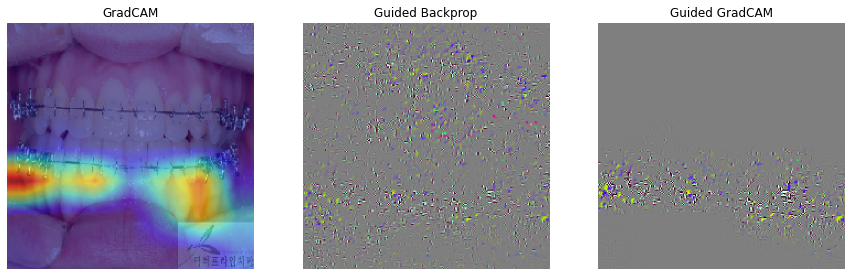

In [17]:
gradcam, gb, guided_gradcam = compute_saliency(input_model=custom_mobilnetv2_model, guided_model=guided_model, img_path='/content/drive/My Drive/transfer_learning_data/60.jpeg', layer_name='out_relu', filename='name',  visualize=True, save=False)